In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Upload Data From CSV to dataframe
data = pd.read_csv("data2.csv")

In [3]:
# Drop the columns with more than 20% missing values
threshold = 0.2
missing_percentage = data.isnull().sum() / len(data)
filtered_data = data.loc[:, missing_percentage <= threshold]

In [4]:
# Split into categorical and numerical columns
categorical_cols = filtered_data.select_dtypes(include=['object']).columns
numerical_cols = filtered_data.select_dtypes(exclude=['object']).columns

# Label encoding for categorical columns and Impute missing values
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))
    label_encoders[col] = le

imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data_numerical = pd.DataFrame(imputer.fit_transform(filtered_data[numerical_cols]), columns=numerical_cols)

imputed_data = pd.concat([imputed_data_numerical, filtered_data[categorical_cols]], axis=1)

print(imputed_data.head())

C:\Users\eric9\AppData\Local\Temp\ipykernel_14540\1452188087.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))
C:\Users\eric9\AppData\Local\Temp\ipykernel_14540\1452188087.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[col] = le.fit_transform(filtered_data[col].astype(str))


   subject_id  los_hospital  anchor_age  glucose_mean  heart_rate_mean  \
0  13248510.0           3.0        19.0     89.300000        79.814815   
1  15680483.0           4.0        21.0    179.000000        78.160000   
2  12832775.0          71.0        22.0    138.818182        94.645833   
3  12832775.0          71.0        22.0    201.807692       116.607143   
4  10810063.0           8.0        22.0    122.400000        90.527778   

     sbp_mean   dbp_mean    mbp_mean  resp_rate_mean  temperature_mean  ...  \
0  151.468085  87.957447  107.468085       19.444444         37.102857  ...   
1  108.538462  53.076923   65.615385       15.600000         36.380000  ...   
2  111.126316  53.647368   70.752632       25.041237         38.585000  ...   
3  135.560000  67.920000   81.920000       21.535714         37.250000  ...   
4  113.385714  71.028571   86.157143       25.527778         36.974286  ...   

   diabetes_without_cc  paraplegia  malignant_cancer  severe_liver_disease  \
0 

In [5]:
#Feature Selection using Recursive Feature Elimination
rfc = RandomForestClassifier(random_state=42)
# Using Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rfc, n_features_to_select=10)  
X = imputed_data.drop('AKI', axis=1)
y = imputed_data['AKI']
# Fit RFE
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]

In [6]:
# Calculating P values to match with p values in document
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

X = imputed_data.drop('AKI', axis=1)
vif_df = calculate_vif(X)
features_to_keep = vif_df[vif_df["VIF"] < 10]["Feature"].tolist()
X_reduced = X[features_to_keep]

y = imputed_data['AKI']
p_values = {}

for feature in X_reduced.columns:
    X_feature = X_reduced[feature]
    X_feature = sm.add_constant(X_feature) 
    try:
        logit_model = sm.Logit(y, X_feature).fit(disp=0)  
        p_value = logit_model.pvalues[1] 
        p_values[feature] = p_value
    except np.linalg.LinAlgError:
        print(f"Skipping {feature} due to singular matrix issue.")

# Display p-values
for feature, p_value in p_values.items():
    print(f"{feature}: {p_value}")

Skipping aids due to singular matrix issue.
los_hospital: 7.120997256609843e-21
glucose_mean: 2.853045626606697e-10
platelets_max: 0.06574233648025259
wbc_max: 3.2064998328556353e-08
bun_max: 3.2385879629607976e-22
creatinine_max: 7.872591226219601e-20
glucose_max: 3.964866337038792e-09
alt_max: 0.04697122863525667
alp_max: 0.16841954120139535
ast_max: 0.017389876136820373
bilirubin_total_max: 0.02032421499901694
myocardial_infarct: 0.032697493044495214
congestive_heart_failure: 0.0020746786450817865
peripheral_vascular_disease: 0.9099741184616483
dementia: 0.7047832797112237
cerebrovascular_disease: 0.21888251565982975
chronic_pulmonary_disease: 0.4994662667663514
rheumatic_disease: 0.804708738666718
peptic_ulcer_disease: 0.2799074093468432
mild_liver_disease: 0.09039327954364557
diabetes_without_cc: 0.04834266900615464
paraplegia: 0.20015172696392924
malignant_cancer: 0.5639227512275757
severe_liver_disease: 0.015450279660040322
metastatic_solid_tumor: 0.19637023120691388
total_urine

C:\Users\eric9\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\eric9\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


In [7]:
#Splitting data into training and testing sets
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [8]:
# Training Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Making predictions
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluating the model
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Random Forest AUC Score: {auc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Random Forest AUC Score: 0.8641388975397072
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.59      0.62        78
         1.0       0.87      0.90      0.89       247

    accuracy                           0.82       325
   macro avg       0.76      0.74      0.75       325
weighted avg       0.82      0.82      0.82       325

Confusion Matrix:
[[ 46  32]
 [ 25 222]]


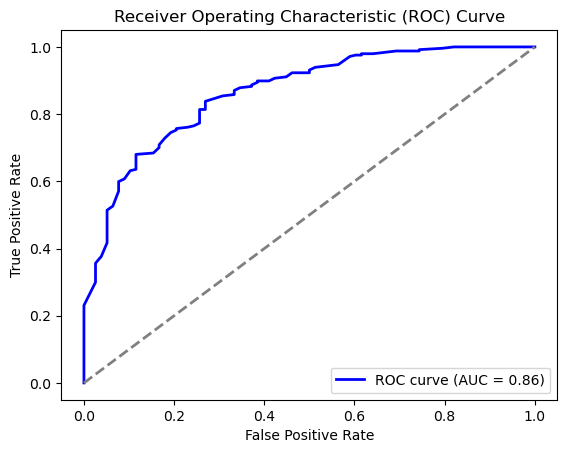

In [10]:
# Step 5: Visualize ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()